In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset
#from features.eegdataset import EEGDataset
from features.neuroinformedeegdataset import EEGDataset, load_and_prepare_data
from models.eegnet1d import ImprovedEEGNet1D_Plus
from models.train_model import train_model, test_model

In [2]:
datapath = ['epochs/epochs/epochs_S01.mat',
            'epochs/epochs/epochs_S02.mat',
            'epochs/epochs/epochs_S03.mat',
            'epochs/epochs/epochs_S04.mat',
            'epochs/epochs/epochs_S05.mat',
            'epochs/epochs/epochs_S06.mat',
            'epochs/epochs/epochs_S07.mat',
            'epochs/epochs/epochs_S08.mat'
           ]

In [3]:
train_dataset, val_dataset, test_dataset, LE = load_and_prepare_data(datapath, test_subject=8)

Загрузка данных субъекта 1: epochs/epochs/epochs_S01.mat
Загрузка данных субъекта 2: epochs/epochs/epochs_S02.mat
Загрузка данных субъекта 3: epochs/epochs/epochs_S03.mat
Загрузка данных субъекта 4: epochs/epochs/epochs_S04.mat
Загрузка данных субъекта 5: epochs/epochs/epochs_S05.mat
Загрузка данных субъекта 6: epochs/epochs/epochs_S06.mat
Загрузка данных субъекта 7: epochs/epochs/epochs_S07.mat
Загрузка данных субъекта 8: epochs/epochs/epochs_S08.mat


In [4]:
print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")
print(f"Классы: {LE.classes_}")

Размер тренировочного датасета: 23505
Размер валидационного датасета: 5877
Размер тестового датасета: 4197
Классы: ['nontarget' 'target']


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = ImprovedEEGNet1D_Plus(
    input_channels=8,  # 8 каналов EEG
    seq_length=250,    # 250 временных точек
    num_classes=2      # 2 класса: target и nontarget
).to(device)

In [8]:
print(sum(p.numel() for p in model.parameters()))

8638


In [9]:
print("Начало обучения...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100
)

Начало обучения...

Epoch 1/100
Train Loss: 0.7561 | Val Loss: 0.6789
Train Acc: 0.4975 | Val Acc: 0.5348
Target F1: 0.2893 | Precision: 0.1813 | Recall: 0.7150
ROC AUC: 0.5348 | Specificity: 0.3546
LR: 1.22e-03 | Grad Norm: 1.0972
Best F1: 0.2893
------------------------------------------------------------

Epoch 2/100
Train Loss: 0.6901 | Val Loss: 0.6741
Train Acc: 0.3666 | Val Acc: 0.5541
Target F1: 0.3041 | Precision: 0.1878 | Recall: 0.7988
ROC AUC: 0.5541 | Specificity: 0.3095
LR: 1.86e-03 | Grad Norm: 0.4335
Best F1: 0.3041
------------------------------------------------------------

Epoch 3/100
Train Loss: 0.6728 | Val Loss: 0.6476
Train Acc: 0.3758 | Val Acc: 0.6042
Target F1: 0.3366 | Precision: 0.2223 | Recall: 0.6936
ROC AUC: 0.6042 | Specificity: 0.5149
LR: 2.86e-03 | Grad Norm: 0.5716
Best F1: 0.3366
------------------------------------------------------------

Epoch 4/100
Train Loss: 0.6471 | Val Loss: 0.6342
Train Acc: 0.5245 | Val Acc: 0.6318
Target F1: 0.3623 | Prec

In [11]:
# Тестируем модель
print("Тестирование модели...")
predictions, true_labels, test_accuracy = test_model(model, test_loader)

print(f"Финальная точность на тесте: {test_accuracy:.2f}%")

Тестирование модели...
Test Accuracy: 67.29%
Test BAccuracy: 0.6669488634829959%
Финальная точность на тесте: 67.29%


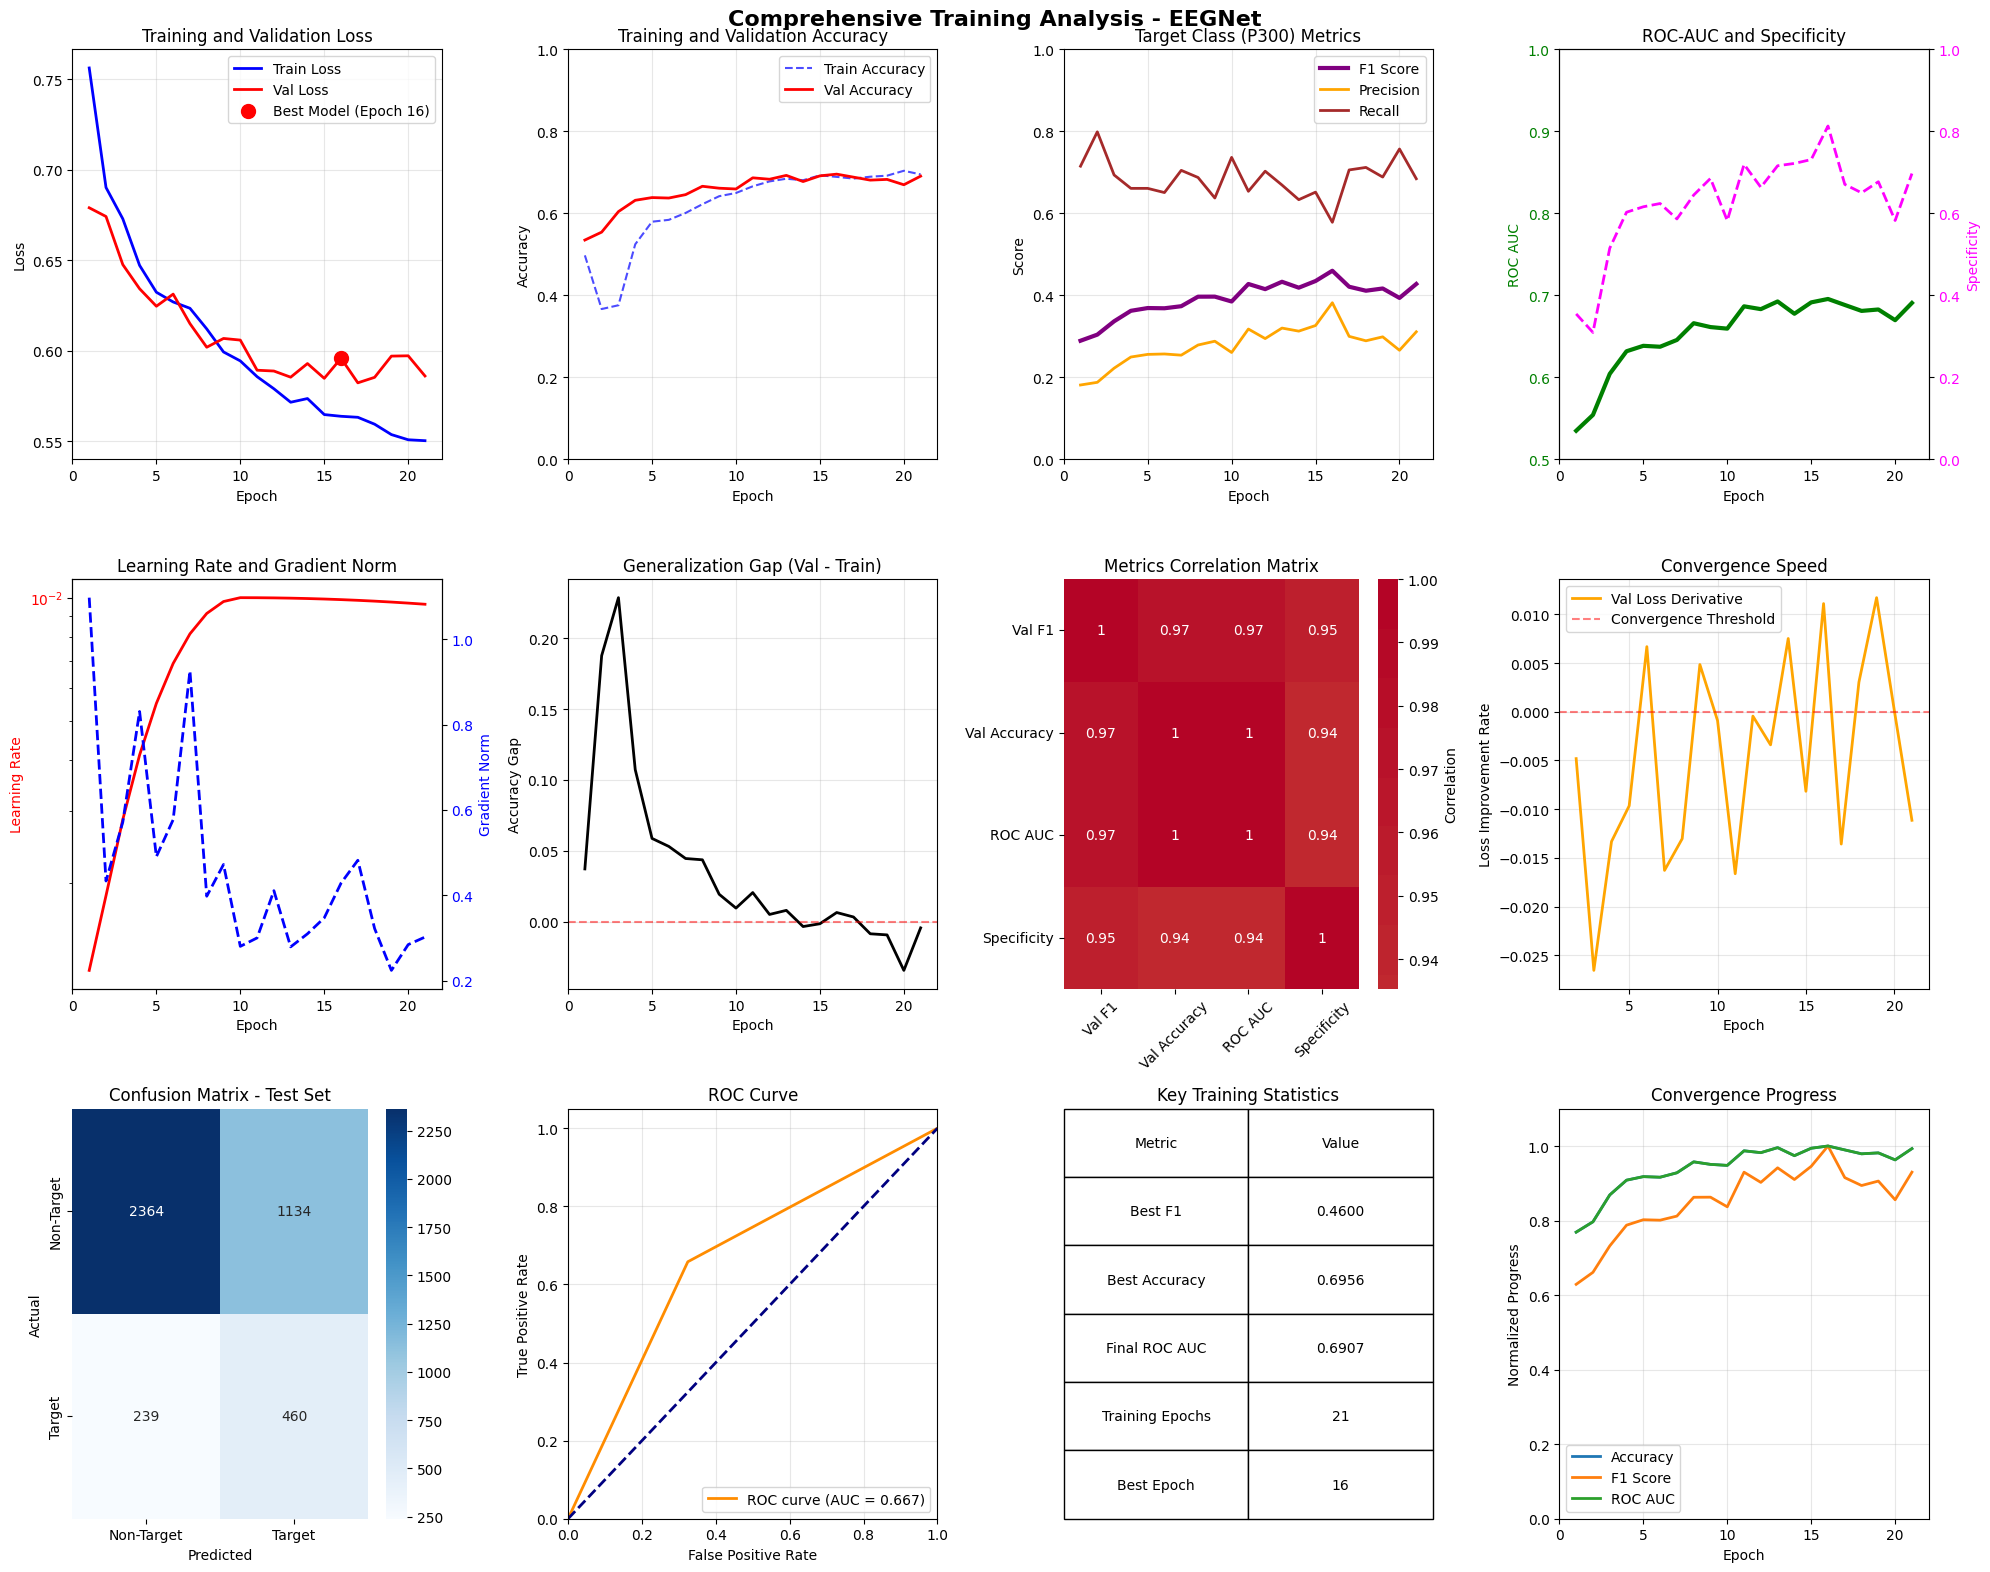

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

def plot_comprehensive_training_analysis(history, test_predictions=None, test_labels=None, model_name="EEGNet"):
    """Комплексный анализ процесса обучения"""
    
    epochs = history["epoch"]
    
    # Создаем сетку графиков
    fig = plt.figure(figsize=(20, 16))
    
    # 1. ГРАФИК ПОТЕРЬ И ТОЧНОСТИ
    plt.subplot(3, 4, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", color="blue", linewidth=2)
    plt.plot(epochs, history["val_loss"], label="Val Loss", color="red", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Добавляем точку лучшей модели
    if "best_epoch" in history:
        best_epoch = history["best_epoch"]
        best_val_loss = history["val_loss"][best_epoch]
        plt.scatter(best_epoch + 1, best_val_loss, color='red', s=100, 
                   label=f'Best Model (Epoch {best_epoch + 1})', zorder=5)
        plt.legend()
    
    # 2. ГРАФИК ТОЧНОСТИ
    plt.subplot(3, 4, 2)
    plt.plot(epochs, history["train_accuracy"], label="Train Accuracy", color="blue", linestyle="--", alpha=0.7)
    plt.plot(epochs, history["val_accuracy"], label="Val Accuracy", color="red", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. МЕТРИКИ ЦЕЛЕВОГО КЛАССА (P300)
    plt.subplot(3, 4, 3)
    plt.plot(epochs, history["val_f1_target"], label="F1 Score", color="purple", linewidth=3)
    plt.plot(epochs, history["val_precision_target"], label="Precision", color="orange", linewidth=2)
    plt.plot(epochs, history["val_recall_target"], label="Recall", color="brown", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Target Class (P300) Metrics")
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. ROC-AUC И СПЕЦИФИЧНОСТЬ
    plt.subplot(3, 4, 4)
    ax1 = plt.gca()
    ax1.plot(epochs, history["ROC_AUC"], label="ROC AUC", color="green", linewidth=3)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("ROC AUC", color="green")
    ax1.set_ylim([0.5, 1.0])
    ax1.tick_params(axis='y', labelcolor="green")
    
    ax2 = ax1.twinx()
    ax2.plot(epochs, history["specificity"], label="Specificity", color="magenta", linewidth=2, linestyle="--")
    ax2.set_ylabel("Specificity", color="magenta")
    ax2.set_ylim([0, 1])
    ax2.tick_params(axis='y', labelcolor="magenta")
    plt.title("ROC-AUC and Specificity")
    
    # 5. LEARNING RATE И НОРМА ГРАДИЕНТОВ
    plt.subplot(3, 4, 5)
    ax1 = plt.gca()
    ax1.plot(epochs, history["learning_rate"], label="Learning Rate", color="red", linewidth=2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Learning Rate", color="red")
    ax1.set_yscale("log")
    ax1.tick_params(axis='y', labelcolor="red")
    
    ax2 = ax1.twinx()
    ax2.plot(epochs, history["grad_norm"], label="Grad Norm", color="blue", linewidth=2, linestyle="--")
    ax2.set_ylabel("Gradient Norm", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")
    plt.title("Learning Rate and Gradient Norm")
    
    # 6. СОПОСТАВЛЕНИЕ TRAIN/VAL METRICS
    plt.subplot(3, 4, 6)
    train_val_gap = np.array(history["val_accuracy"]) - np.array(history["train_accuracy"])
    plt.plot(epochs, train_val_gap, label="Val - Train Accuracy Gap", color="black", linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy Gap")
    plt.title("Generalization Gap (Val - Train)")
    plt.grid(True, alpha=0.3)
    
    # 7. КОРРЕЛЯЦИЯ МЕТРИК
    plt.subplot(3, 4, 7)
    metrics_to_correlate = {
        'Val F1': history["val_f1_target"],
        'Val Accuracy': history["val_accuracy"],
        'ROC AUC': history["ROC_AUC"],
        'Specificity': history["specificity"]
    }
    
    # Вычисляем корреляции
    corr_matrix = np.corrcoef([metrics_to_correlate[key] for key in metrics_to_correlate])
    sns.heatmap(corr_matrix, annot=True, xticklabels=metrics_to_correlate.keys(), 
                yticklabels=metrics_to_correlate.keys(), cmap="coolwarm", center=0,
                cbar_kws={'label': 'Correlation'})
    plt.title("Metrics Correlation Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 8. СКОРОСТЬ СХОДИМОСТИ
    plt.subplot(3, 4, 8)
    # Вычисляем производную потерь (скорость уменьшения)
    if len(history["val_loss"]) > 1:
        loss_derivative = np.diff(history["val_loss"])
        epochs_derivative = epochs[1:]
        plt.plot(epochs_derivative, loss_derivative, label="Val Loss Derivative", color="orange", linewidth=2)
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label="Convergence Threshold")
        plt.xlabel("Epoch")
        plt.ylabel("Loss Improvement Rate")
        plt.title("Convergence Speed")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 9. CONFUSION MATRIX (если есть тестовые данные)
    if test_predictions is not None and test_labels is not None:
        plt.subplot(3, 4, 9)
        cm = confusion_matrix(test_labels, test_predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Non-Target', 'Target'], 
                   yticklabels=['Non-Target', 'Target'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix - Test Set')
    
    # 10. ROC CURVE (если есть вероятности)
    plt.subplot(3, 4, 10)
    if test_predictions is not None and test_labels is not None:
        fpr, tpr, _ = roc_curve(test_labels, test_predictions)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
    
    # 11. МЕТРИКИ ПО ЭПОХАМ В ТАБЛИЧНОМ ВИДЕ
    plt.subplot(3, 4, 11)
    # Создаем упрощенную таблицу ключевых метрик
    key_metrics = {
        'Best F1': f"{history.get('best_f1', max(history['val_f1_target'])):.4f}",
        'Best Accuracy': f"{max(history['val_accuracy']):.4f}",
        'Final ROC AUC': f"{history['ROC_AUC'][-1]:.4f}",
        'Training Epochs': f"{len(epochs)}",
        'Best Epoch': f"{history.get('best_epoch', np.argmax(history['val_f1_target'])) + 1}"
    }
    
    plt.axis('off')
    table_data = [[k, v] for k, v in key_metrics.items()]
    table = plt.table(cellText=table_data, 
                     colLabels=['Metric', 'Value'],
                     loc='center', 
                     cellLoc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Key Training Statistics')
    
    # 12. ДИАГРАММА СХОДИМОСТИ
    plt.subplot(3, 4, 12)
    # Показываем прогресс по всем основным метрикам
    metrics_progress = {
        'Accuracy': history["val_accuracy"],
        'F1 Score': history["val_f1_target"],
        'ROC AUC': history["ROC_AUC"]
    }
    
    for metric_name, values in metrics_progress.items():
        normalized_progress = [v/max(values) for v in values] if max(values) > 0 else values
        plt.plot(epochs, normalized_progress, label=metric_name, linewidth=2)
    
    plt.xlabel("Epoch")
    plt.ylabel("Normalized Progress")
    plt.title("Convergence Progress")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.1])

    plt.suptitle(f'Comprehensive Training Analysis - {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ДОПОЛНИТЕЛЬНЫЕ СПЕЦИАЛИЗИРОВАННЫЕ ГРАФИКИ

# Вызов функции
plot_comprehensive_training_analysis(history, test_predictions=predictions, test_labels=true_labels, model_name="EEGNet")


🔍 COMPREHENSIVE TRAINING ANALYSIS


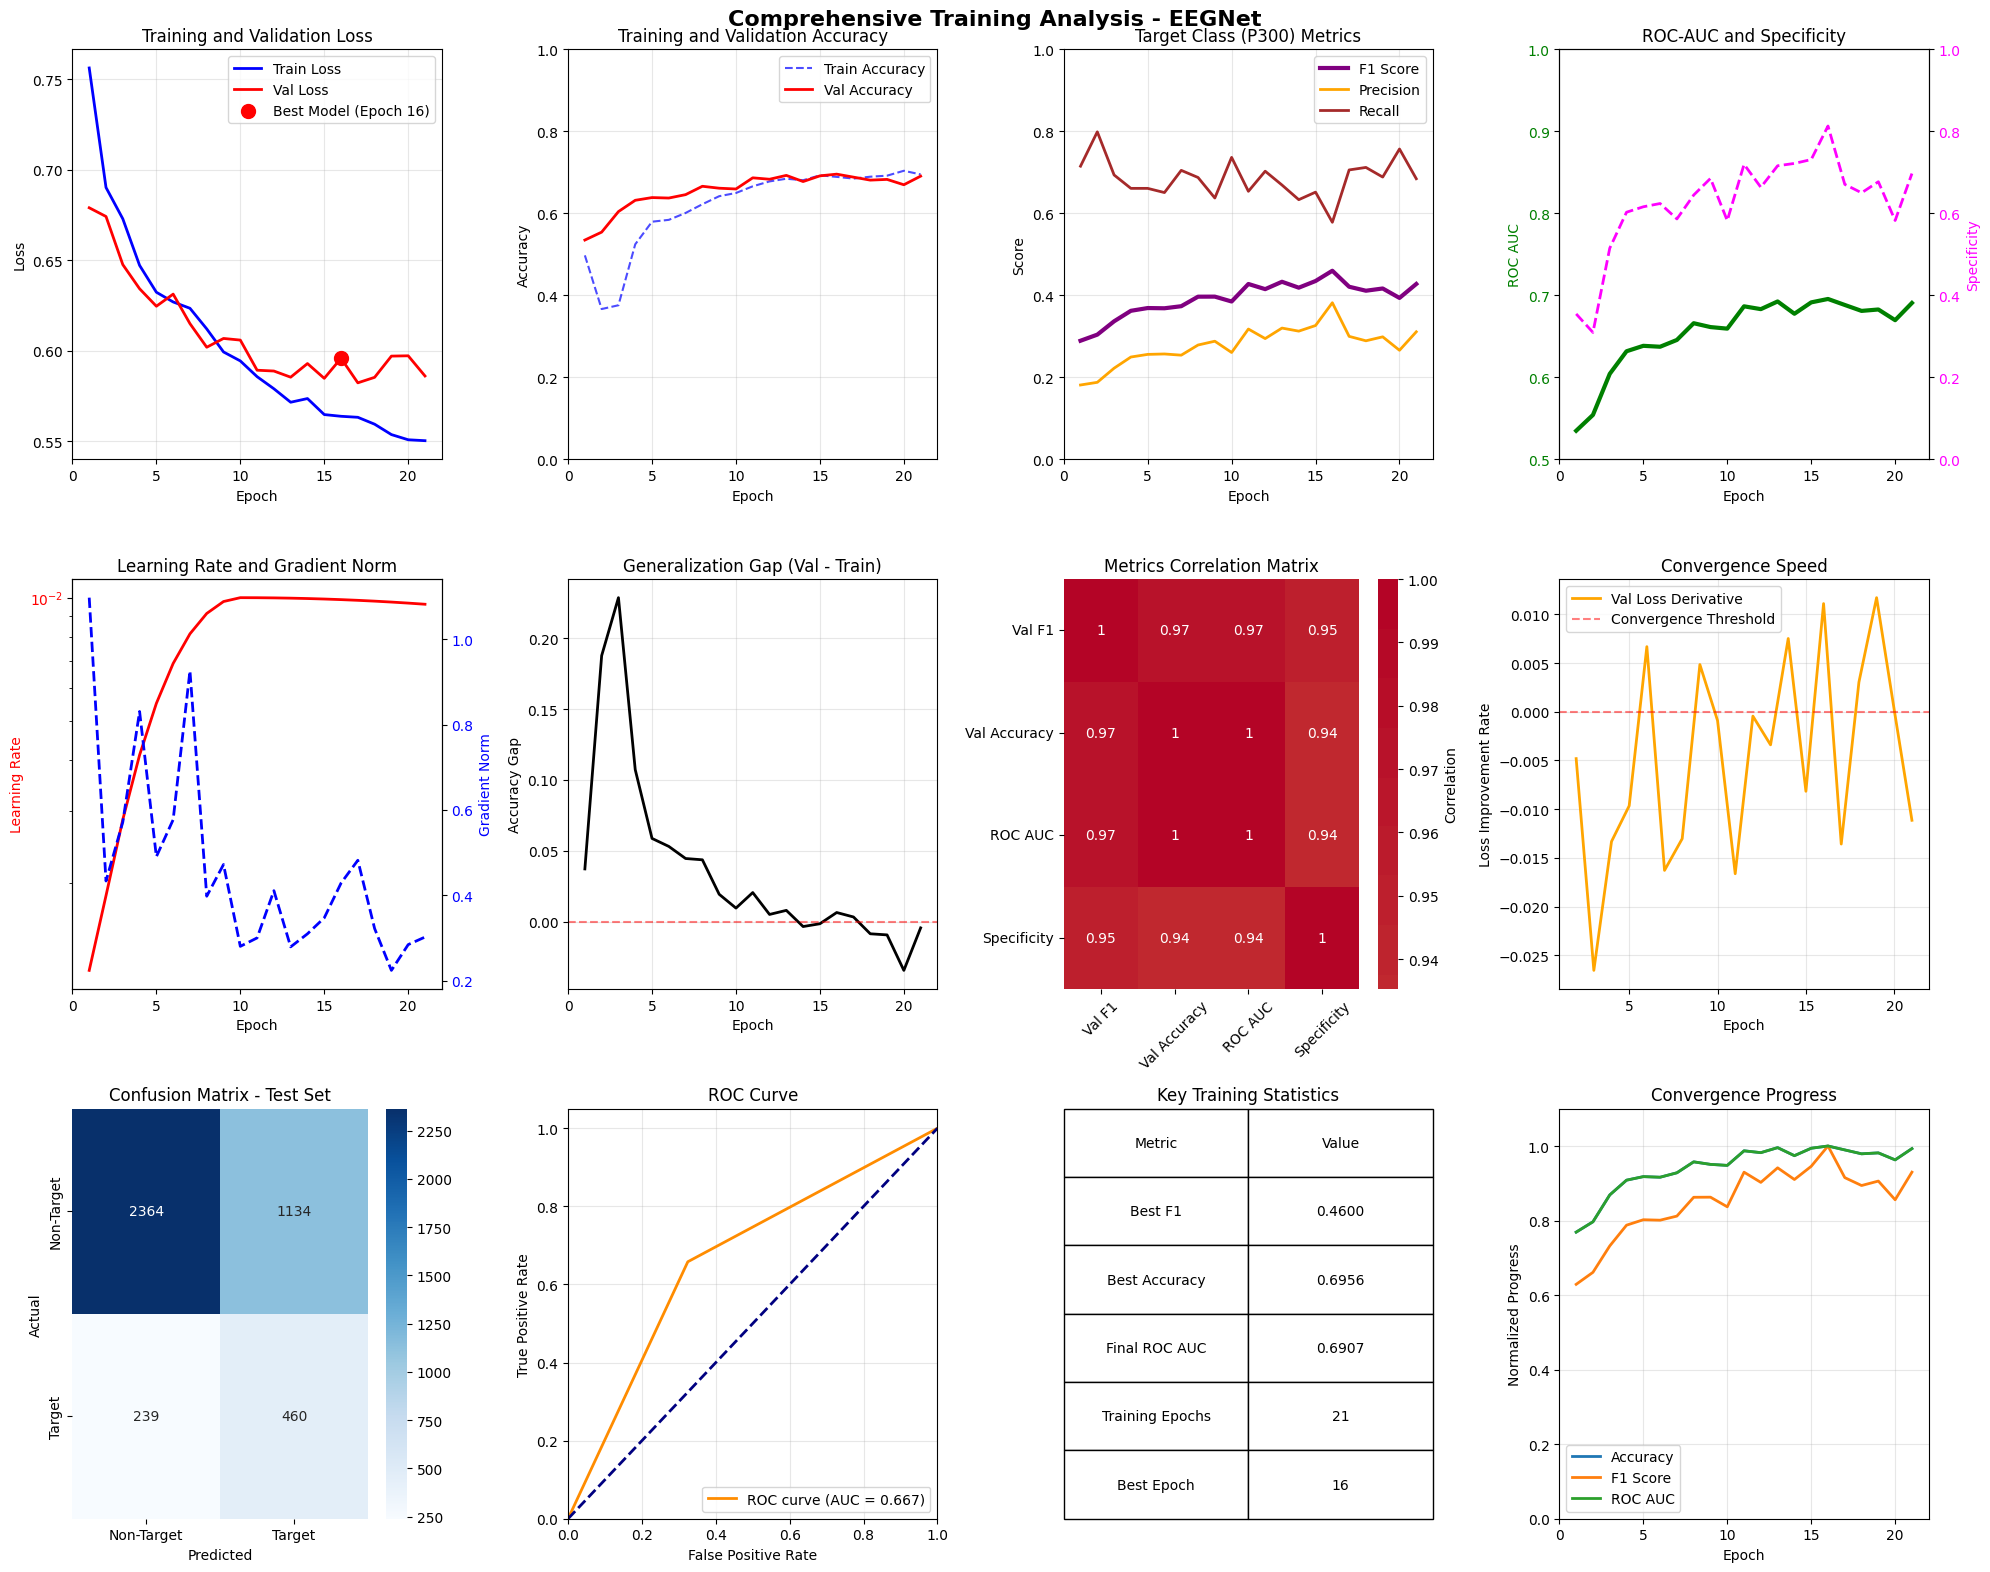

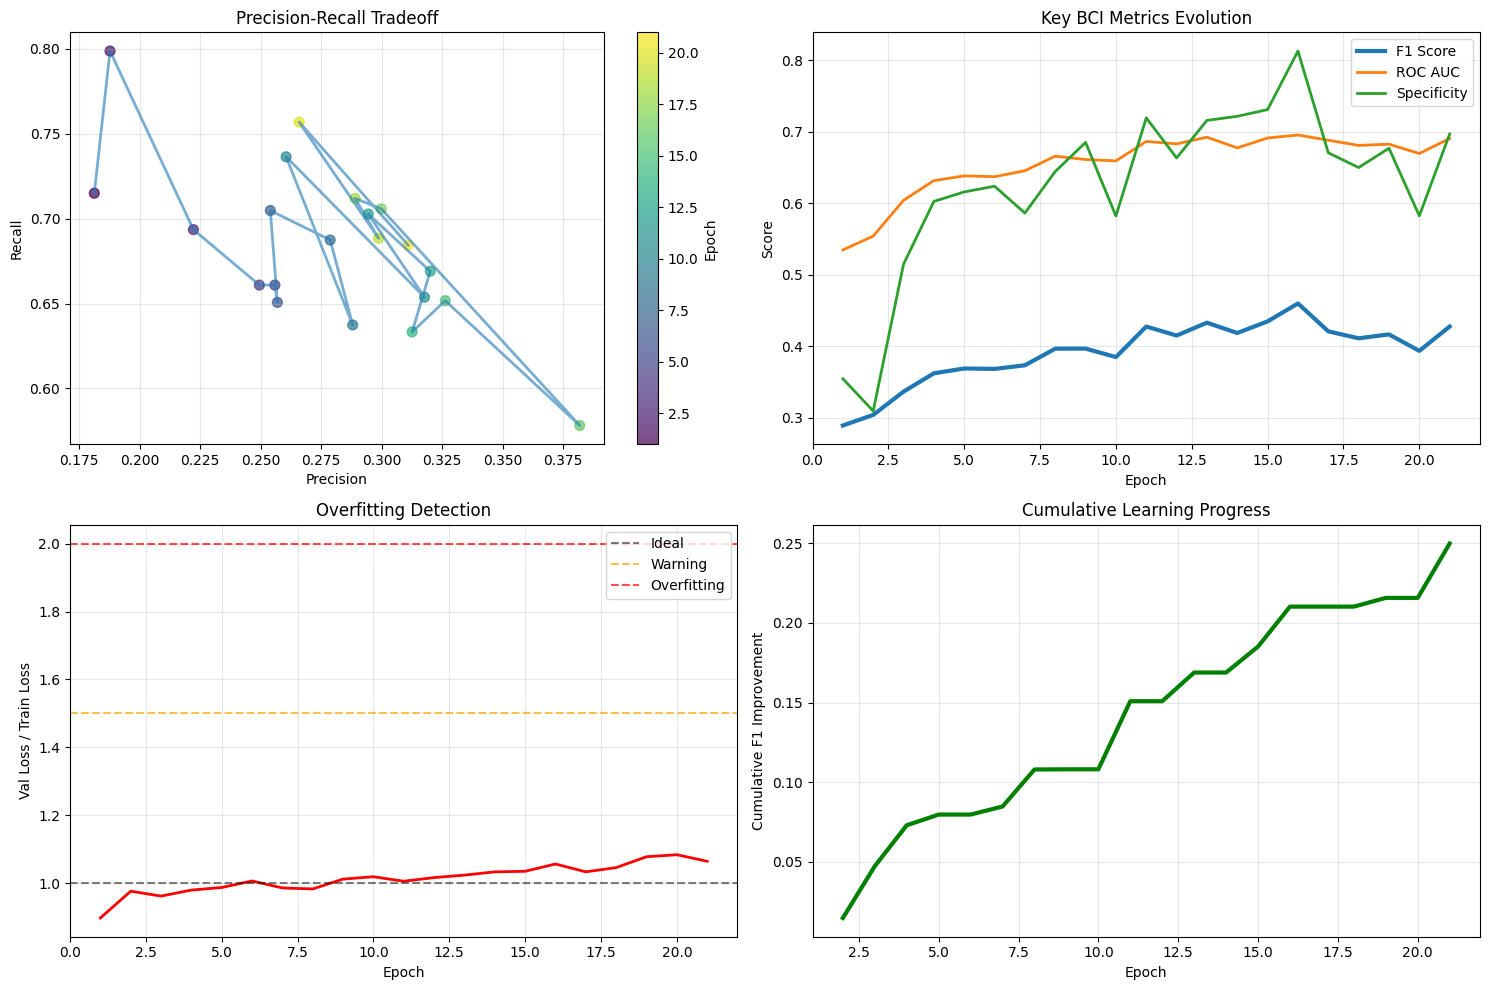


📊 KEY INSIGHTS:
• Best Target F1: 0.4600
• Final ROC AUC: 0.6907
• Training Stability: GOOD
• Overfitting Risk: LOW
Report exported to EEGNet_training_report.png


<Figure size 2500x2000 with 0 Axes>

In [13]:
def plot_bci_specific_analysis(history, test_predictions=predictions, test_labels=true_labels):
    """Специфические графики для анализа BCI классификации"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = history["epoch"]
    
    # 1. БАЛАНС МЕЖДУ PRECISION И RECALL
    axes[0, 0].plot(history["val_precision_target"], history["val_recall_target"], 
                   alpha=0.6, linewidth=2)
    scatter = axes[0, 0].scatter(history["val_precision_target"], history["val_recall_target"], 
                               c=epochs, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter, ax=axes[0, 0], label='Epoch')
    axes[0, 0].set_xlabel('Precision')
    axes[0, 0].set_ylabel('Recall')
    axes[0, 0].set_title('Precision-Recall Tradeoff')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. ВРЕМЕННАЯ ДИНАМИКА ВАЖНЫХ МЕТРИК
    axes[0, 1].plot(epochs, history["val_f1_target"], label='F1 Score', linewidth=3)
    axes[0, 1].plot(epochs, history["ROC_AUC"], label='ROC AUC', linewidth=2)
    axes[0, 1].plot(epochs, history["specificity"], label='Specificity', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Key BCI Metrics Evolution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. АНАЛИЗ ПЕРЕОБУЧЕНИЯ
    overfitting_ratio = np.array(history["val_loss"]) / np.array(history["train_loss"])
    axes[1, 0].plot(epochs, overfitting_ratio, color='red', linewidth=2)
    axes[1, 0].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Ideal')
    axes[1, 0].axhline(y=1.5, color='orange', linestyle='--', alpha=0.7, label='Warning')
    axes[1, 0].axhline(y=2.0, color='red', linestyle='--', alpha=0.7, label='Overfitting')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Val Loss / Train Loss')
    axes[1, 0].set_title('Overfitting Detection')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. КУМУЛЯТИВНЫЙ ПРОГРЕСС
    cumulative_improvement = np.cumsum([max(0, x) for x in np.diff(history["val_f1_target"])])
    axes[1, 1].plot(epochs[1:], cumulative_improvement, color='green', linewidth=3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Cumulative F1 Improvement')
    axes[1, 1].set_title('Cumulative Learning Progress')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ФУНКЦИЯ ДЛЯ ЭКСПОРТА РЕЗУЛЬТАТОВ
def export_training_report(history, filename="training_report.png"):
    """Экспорт полного отчета в файл"""
    plt.figure(figsize=(25, 20))
    
    # [Здесь код комплексной визуализации...]
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Report exported to {filename}")

# ИСПОЛЬЗОВАНИЕ
def analyze_training_results(history, test_predictions=predictions, test_labels=true_labels, model_name="EEGNet"):
    """Полный анализ результатов обучения"""
    
    print("🔍 COMPREHENSIVE TRAINING ANALYSIS")
    print("=" * 50)
    
    # Основные графики
    plot_comprehensive_training_analysis(history, test_predictions, test_labels, model_name)
    
    # BCI-специфичные графики
    plot_bci_specific_analysis(history, test_predictions, test_labels)
    
    # Текстовый анализ
    print("\n📊 KEY INSIGHTS:")
    print(f"• Best Target F1: {max(history['val_f1_target']):.4f}")
    print(f"• Final ROC AUC: {history['ROC_AUC'][-1]:.4f}")
    print(f"• Training Stability: {'GOOD' if np.std(history['val_loss'][-10:]) < 0.1 else 'UNSTABLE'}")
    print(f"• Overfitting Risk: {'LOW' if history['val_loss'][-1] < history['train_loss'][-1] * 1.2 else 'HIGH'}")
    
    # Экспорт отчета
    export_training_report(history, f"{model_name}_training_report.png")

# ВЫЗОВ ФУНКЦИИ
analyze_training_results(history, test_predictions=predictions, test_labels=true_labels, model_name="EEGNet")

In [14]:
# Сохранение истории
import pandas as pd
df_history = pd.DataFrame(history)
df_history.to_csv('training_history.csv', index=False)

In [15]:
# Сохраняем модель
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': LE,
    'test_accuracy': test_accuracy
}, 'eeg_target_classifier_2.pth')

print("Модель сохранена как 'eeg_target_classifier_2.pth'")

Модель сохранена как 'eeg_target_classifier_2.pth'


In [16]:
from scipy.io import loadmat
def evaluate_single_subject(subject_idx):
    """Оценивает модель на конкретном субъекте"""
    file_paths = [
        'epochs/epochs/epochs_S01.mat',
        'epochs/epochs/epochs_S02.mat', 
        'epochs/epochs/epochs_S03.mat',
        'epochs/epochs/epochs_S04.mat',
        'epochs/epochs/epochs_S05.mat',
        'epochs/epochs/epochs_S06.mat',
        'epochs/epochs/epochs_S07.mat',
        'epochs/epochs/epochs_S08.mat'
    ]
    
    # Загружаем модель
    checkpoint = torch.load('eeg_target_classifier_2.pth', weights_only=False)
    model = ImprovedEEGNet1D_Plus(input_channels=8, seq_length=250, num_classes=2)
    model.load_state_dict(checkpoint['model_state_dict'])
    label_encoder = checkpoint['label_encoder']
    
    # Загружаем данные конкретного субъекта
    data = loadmat(file_paths[subject_idx])
    tar_eeg = data['tar_eeg'].transpose(0, 2, 1)  # (700, 8, 250)
    nontar_eeg = data['nontar_eeg'].transpose(0, 2, 1)  # (3500, 8, 250)
    
    test_data = np.concatenate([tar_eeg, nontar_eeg], axis=0)
    test_targets = [('target', j) for j in range(len(tar_eeg))] + [('nontarget', j) for j in range(len(nontar_eeg))]
    
    test_dataset = EEGDataset(test_data, test_targets, augment=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    predictions, true_labels, accuracy = test_model(model, test_loader)
    
    print(f"Точность на субъекте S{subject_idx+1:02d}: {accuracy:.2f}%")
    
    # Детальная статистика
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    print("\nДетальная классификация:")
    print(classification_report(true_labels, predictions, 
                              target_names=label_encoder.classes_))
    
    # Матрица ошибок
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'Матрица ошибок - Субъект S{subject_idx+1:02d}')
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.show()


Test Accuracy: 73.05%
Test BAccuracy: 0.7314285714285714%
Точность на субъекте S01: 73.05%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.93      0.73      0.82      3500
      target       0.35      0.73      0.48       700

    accuracy                           0.73      4200
   macro avg       0.64      0.73      0.65      4200
weighted avg       0.84      0.73      0.76      4200



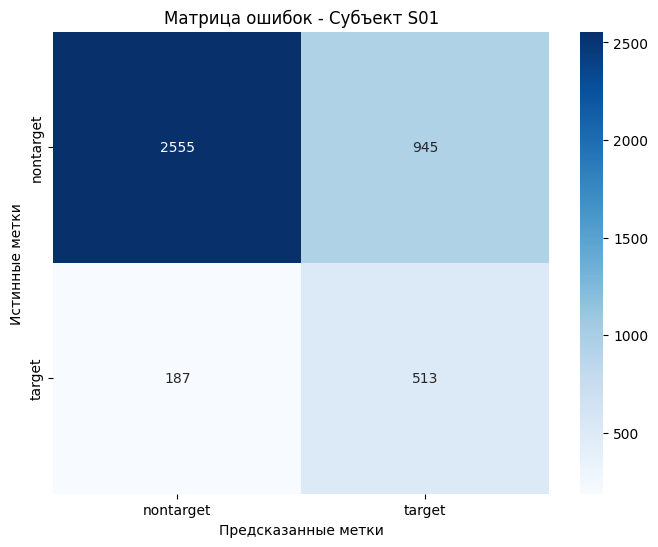

Test Accuracy: 65.14%
Test BAccuracy: 0.6777021120143797%
Точность на субъекте S02: 65.14%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.92      0.64      0.75      3497
      target       0.28      0.72      0.41       700

    accuracy                           0.65      4197
   macro avg       0.60      0.68      0.58      4197
weighted avg       0.81      0.65      0.70      4197



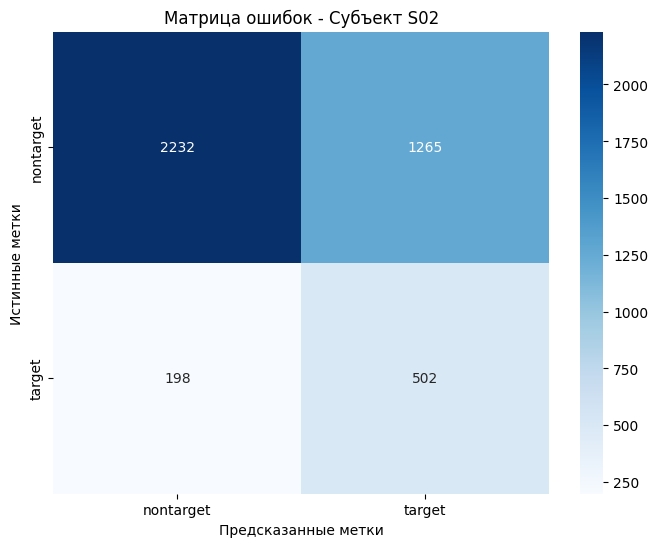

Test Accuracy: 70.57%
Test BAccuracy: 0.733109676364825%
Точность на субъекте S03: 70.57%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.94      0.69      0.80      3496
      target       0.33      0.77      0.47       700

    accuracy                           0.71      4196
   macro avg       0.64      0.73      0.63      4196
weighted avg       0.84      0.71      0.74      4196



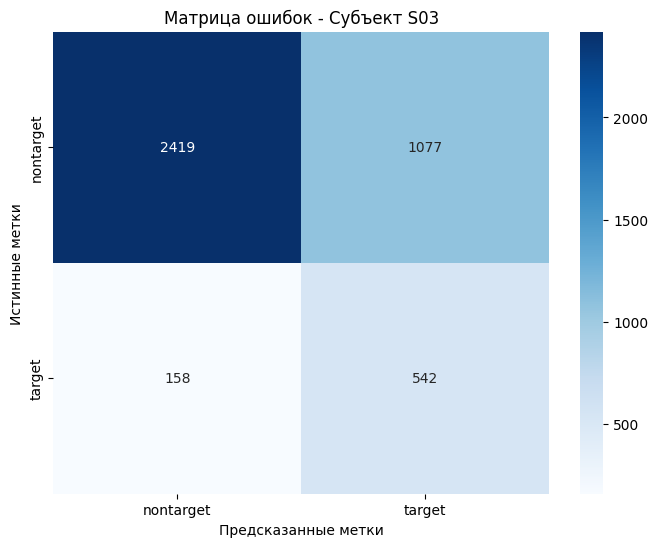

Test Accuracy: 75.05%
Test BAccuracy: 0.745599570079285%
Точность на субъекте S04: 75.05%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.94      0.75      0.83      3498
      target       0.37      0.74      0.50       699

    accuracy                           0.75      4197
   macro avg       0.65      0.75      0.67      4197
weighted avg       0.84      0.75      0.78      4197



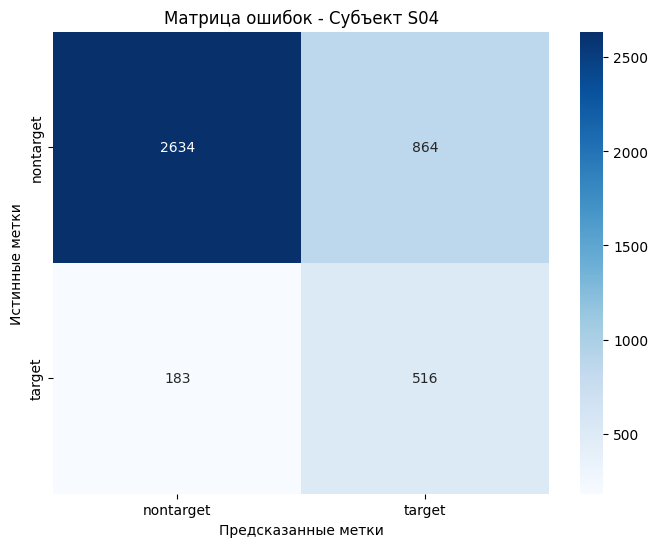

Test Accuracy: 72.15%
Test BAccuracy: 0.729160644342919%
Точность на субъекте S05: 72.15%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.93      0.72      0.81      3499
      target       0.34      0.74      0.47       698

    accuracy                           0.72      4197
   macro avg       0.64      0.73      0.64      4197
weighted avg       0.83      0.72      0.75      4197



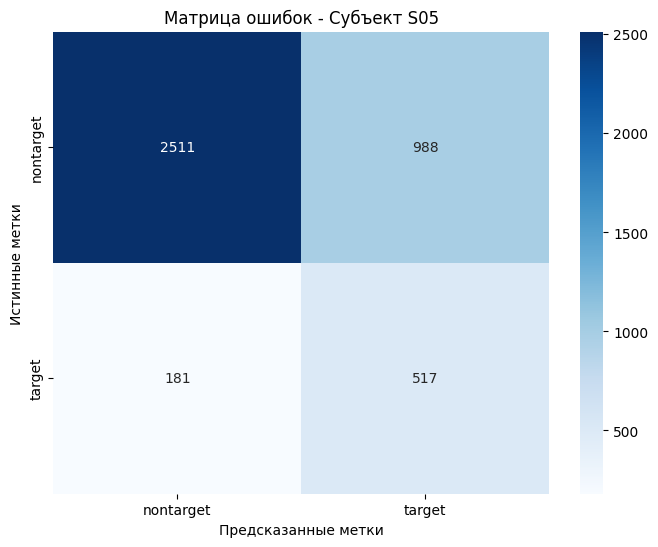

Test Accuracy: 72.60%
Test BAccuracy: 0.7475922219044896%
Точность на субъекте S06: 72.60%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.94      0.72      0.81      3497
      target       0.35      0.78      0.49       700

    accuracy                           0.73      4197
   macro avg       0.65      0.75      0.65      4197
weighted avg       0.84      0.73      0.76      4197



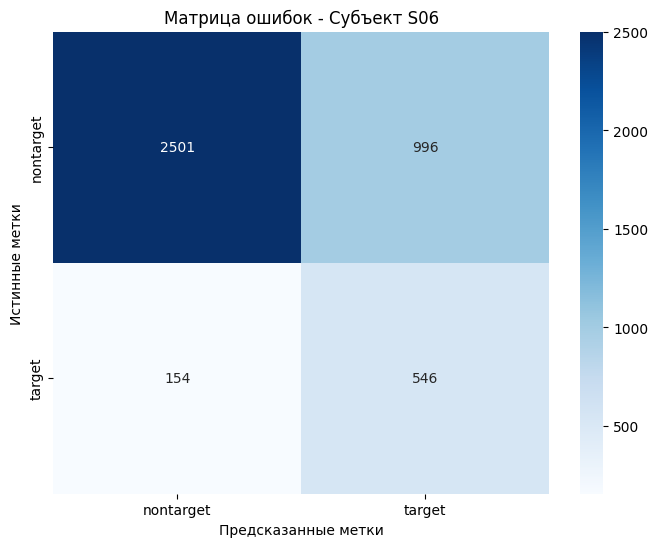

Test Accuracy: 77.37%
Test BAccuracy: 0.7857196070405239%
Точность на субъекте S07: 77.37%

Детальная классификация:
              precision    recall  f1-score   support

   nontarget       0.95      0.77      0.85      3500
      target       0.41      0.80      0.54       698

    accuracy                           0.77      4198
   macro avg       0.68      0.79      0.70      4198
weighted avg       0.86      0.77      0.80      4198



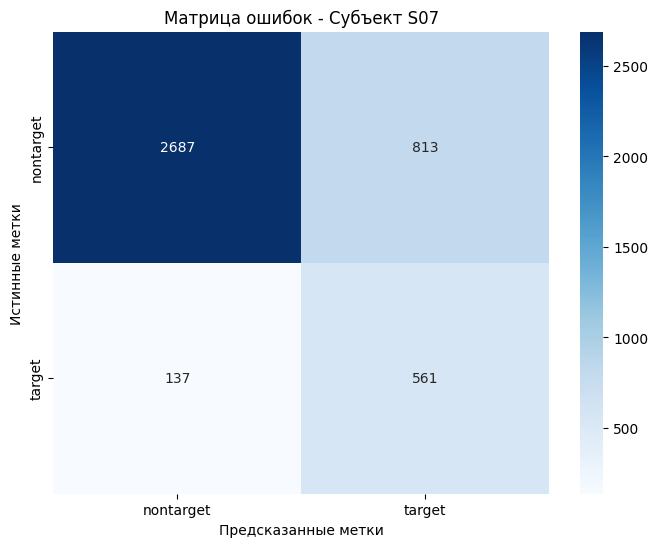

In [ ]:
for i in range(8):
    evaluate_single_subject(i)